# ML testing: experiment #1- unharmonized

This notebook involves testing for the MRI conference abstract. This notebook shows unharmonized StrokeMRI and TOP based models, and how they perform on each other

### import libraries

In [1]:
import os       # using operating system dependent functionality (folders)
import sys
import glob
from functools import reduce

import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
import seaborn as sns

# ml stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import ExtraTreesRegressor
import joblib

sys.path.insert(0, '../') # path to functions
import cvasl.seperated as sep
from cvasl.file_handler import Config
import cvasl.harmony as har

### import data , clean and prep

In [2]:
filepath_mri = '../open_work/internal_results/cleaned_pvc2s/' 
filename_mri = os.path.join(filepath_mri,'StrokeMRI_pvc2c.csv') 
filepath_top = '../open_work/internal_results/cleaned_pvc2s/' 
filename_top = os.path.join(filepath_top,'TOP_pvc2c.csv') 
TOP = pd.read_csv(filename_top)
StrokeMRI = pd.read_csv(filename_mri)
TOP = TOP.drop(TOP.columns[0],axis=1)
StrokeMRI = StrokeMRI.drop(StrokeMRI.columns[0],axis=1)

# Now we need to flip the sex back to numbers for a correlation
sex_mapping = {'F':0,'M':1}
TOP = TOP.assign(sex = TOP.sex.map(sex_mapping))
StrokeMRI = StrokeMRI.assign(sex = StrokeMRI.sex.map(sex_mapping))
TOP.head(3)

,participant_id,age,sex,gm_vol,wm_vol,csf_vol,gm_ivc_ratio,gmwm_ivc_ratio,wmh_vol,wmh_count,deepwm_b_cov,aca_b_cov,mca_b_cov,pca_b_cov,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b
0,sub-0001_1_ses-1_run-1,43.49,1,0.71736,0.52803,0.31812,0.45881,0.79653,1.743,24.0,8.7620,2.2748,2.3205,2.6858,2.4316,22.1022,80.4744,68.3224,52.4614,60.6981
1,sub-0002_1_ses-1_run-1,38.30,0,0.72383,0.62394,0.25673,0.45112,0.83999,1.629,23.0,9.0749,1.7564,2.3989,1.5982,1.9738,23.5401,87.3972,78.0359,63.9932,71.6047
2,sub-0019_1_ses-1_run-1,32.30,1,0.71224,0.53295,0.33594,0.45046,0.78753,0.621,13.0,8.8791,1.9850,1.8702,2.1648,2.1723,27.5573,94.0855,86.3816,62.6012,74.0588


In [3]:
StrokeMRI.head(3)

,participant_id,age,sex,gm_vol,wm_vol,csf_vol,gm_ivc_ratio,gmwm_ivc_ratio,wmh_vol,wmh_count,deepwm_b_cov,aca_b_cov,mca_b_cov,pca_b_cov,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b
0,sub-59082_1_ses-1_run-1,43.172603,0,0.64754,0.49441,0.31320,0.44500,0.78476,1.249,24.0,8.0434,1.7273,1.9776,1.7141,1.9140,26.8262,104.3155,90.5047,73.8758,84.4527
1,sub-59083_1_ses-1_run-1,66.367123,0,0.60517,0.48594,0.42304,0.39968,0.72061,14.597,25.0,3.7791,1.9669,1.7154,2.6394,1.8815,24.9597,75.7051,65.3032,65.6771,67.1158
2,sub-59085_1_ses-1_run-1,55.838356,0,0.61724,0.53779,0.33692,0.41371,0.77417,6.341,30.0,5.1248,1.8146,1.9845,2.0827,1.9501,27.7117,81.0966,72.9980,60.8317,64.3183


## choose whether to log columns

In [4]:
# examine distributions visually
possibilities = StrokeMRI.columns.to_list()
def see_feature_on_two(a):
    sns.displot(StrokeMRI, x= a, hue= 'sex'), plt.title('StrokeMRI')
    sns.displot(TOP, x= a, hue= 'sex'), plt.title('TOP')
    return a
w = interactive(see_feature_on_two,
                a=widgets.Dropdown(
                    options= possibilities,
                    value='age',
                    description='feature',
                    disabled=False))
w

interactive(children=(Dropdown(description='feature', index=1, options=('participant_id', 'age', 'sex', 'gm_vo…

In [5]:
data = StrokeMRI
features_to_log = widgets.SelectMultiple(
    options=data.columns.tolist(),
    value=[],
    description='Features',
    disabled=False
)
features_to_log

SelectMultiple(description='Features', options=('participant_id', 'age', 'sex', 'gm_vol', 'wm_vol', 'csf_vol',…

In [6]:
list(features_to_log.value)

[]

In [7]:
if len(features_to_log.value) == 0:
    output_folder = '1a_no_log_outputs'
else:
    output_folder = '1a_loged_outputs'

os.makedirs(output_folder, exist_ok=True)

In [8]:
StrokeMRI = har.log_out_columns(StrokeMRI, list(features_to_log.value))
TOP = har.log_out_columns(TOP, list(features_to_log.value))

## add binned column on age

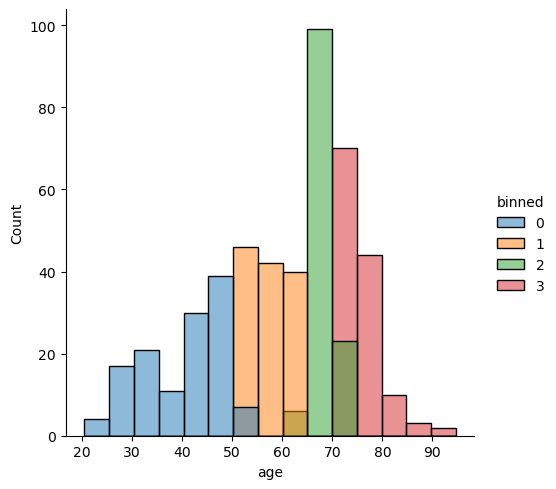

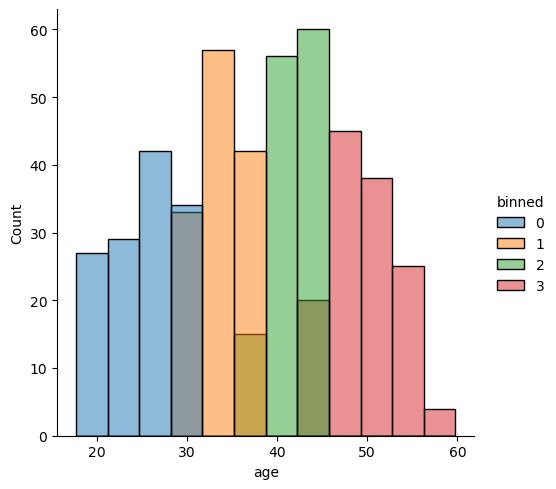

In [9]:
StrokeMRI = har.bin_dataset(StrokeMRI, 'age', num_bins=4, graph = True)
TOP =  har.bin_dataset(TOP, 'age', num_bins=4, graph = True)

In [10]:
## add alterative  for stiff binning choice
this needs to break here so we can think

SyntaxError: invalid syntax (3357442510.py, line 2)

In [ ]:

    
    
# StrokeMRI = sep.static_bin_age(StrokeMRI)
# TOP =  sep.static_bin_age(TOP)
# StrokeMRI.tail(20)

## Build ML models based on StrokeMRI

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
def stratified_two_category_shuffle_split(
        model_name,
        model_file_name,
        scikit_model,
        our_ml_matrix,
        our_x,
        our_y,
        category='sex',
        splits=5,
        test_size_p=0.25,
        printed=False
):
    """
    This takes a sci-kit learn coded model and
    creates a dataframe based on k-folds of results on
    our_ml_matrix, and it's X component
    returns a dataframe of fold results
    and raw y_test versus y_pred
    as well as a tuple with models
    and then the training data from the model.
    The random state in the StratifiedShuffleSplit is set, so
    the results should be reproducible.

    :param model_name: name of model
    :type model_name: str
    :param model_file_name: name offile where specific model will be stored
    :type model_file_name: str
    :param skikit_model: name of skikit-model
    :type skikit_model: str
    :param our_ml_matrix: dataframe to work over
    :type our_ml_matrix: `~pd.DataFrame`
    :param our_x: X or features columnfor machine learning
    :type our_x: dataframe
    :param our_y: y or label column for machine learning
    :type our_y: class:`~pandas.core.series.Series`
    :param category: categorical variable (column) to be stratified on eg. sex
    :type category: list
    :param splits: number of folds desired
    :type splits: int
    :param test_size_p: percent to put into test
    :type test_size_p: float
    :param printed: printed information on folds option
    :type printed: bool


    :returns: dataframe, y dataframe, and models
    :rtype: tuple
    """
    #y_split = our_ml_matrix[category].values
    sss = StratifiedShuffleSplit(
        n_splits=splits,
        test_size=test_size_p,
        random_state=12
    )

    X = our_x
    # TODO: (makeda)finish split and put back index so everything is traceable
    y = our_y
    sss.get_n_splits(X, y,groups= category)

   # unique, counts = np.unique(y_split, return_counts=True)

    y_frame = []
    all_mod_results = []
    models = []
    for i, (train_index, test_index) in enumerate(sss.split(X, y, groups= [X[category[0]], X[category[1]]])):
        unique, counts = np.unique(y_split[train_index], return_counts=True)
        unique, counts = np.unique(y_split[test_index], return_counts=True)
        cols = [
            'algorithm',
            'fold',
            'file_name',
            'mae',
            'r2',
            'explained_variance',
        ]
        mod_results = pd.DataFrame(columns=cols)
        current_fold_X_train = X[train_index][:, 1:]
        current_fold_y_train = y[train_index]
        current_fold_X_test = X[test_index][:, 1:]
        current_fold_y_test = y[test_index]
        scikit_model.fit(current_fold_X_train, current_fold_y_train)
        current_fold_y_pred = scikit_model.predict(current_fold_X_test)
        if printed:
            print(f"\nFold {i}:")
            print(
                f'Train shapes: X {X[train_index].shape}',
                f' y {y[train_index].shape}'
            )
            # unique_train1, uniqe, counts_train = np.unique(
            #     y_split[0][train_index], return_counts=True
            # ), 
            # np.unique(
            #     y_split[1][train_index], return_counts=True
            # )
            # print(
            #     f'Category classes: {unique_train}',
            #     f'percentages: {100*counts_train/y[train_index].shape[0]}'
            # )
            # print(
            #     f'\nTest shapes: X {X[test_index].shape}',
            #     f'  y {y[test_index].shape}'
            # )
            # unique_test, counts_test = np.unique(
            #     y_split[test_index], return_counts=True
            # )
            # print(
            #     f'Category classes: {unique_test},'
            #     f'percentages: {100*counts_test/y[test_index].shape[0]}'
            # )

        data = [[
            f'{model_name}-{i}',
            i,
            f'{model_file_name}.{i}',
            mean_absolute_error(current_fold_y_test, current_fold_y_pred),
            scikit_model.score(current_fold_X_test, current_fold_y_test),
            metrics.explained_variance_score(
                current_fold_y_test,
                current_fold_y_pred
            )]]
        mod_results_current_fold = pd.DataFrame(data, columns=cols)
        mod_results = pd.concat([mod_results, mod_results_current_fold])
        mod_results.reset_index(drop=True, inplace=True)
        all_mod_results.append(mod_results)
        y_frame_now = pd.DataFrame(
            {
                'y_test': list(current_fold_y_test),
                'y_pred': list(current_fold_y_pred),
            })

        y_frame.append(y_frame_now)

        models.append((scikit_model, X[train_index][:, 0]))

    df = pd.concat(all_mod_results)
    y_frame = pd.concat([
        y_frame[0],
        y_frame[1],
        y_frame[2],
        y_frame[3],
        y_frame[4],
    ], axis=0)

    return df, y_frame, models

In [ ]:
# train, test = train_test_split(df, test_size=0.2, random_state=0, 
#                                stratify=df[['b', 'c']])

In [12]:
ml_matrix = StrokeMRI.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')


In [13]:
ml_matrix

,age,sex,gm_vol,wm_vol,csf_vol,gm_ivc_ratio,gmwm_ivc_ratio,wmh_vol,wmh_count,deepwm_b_cov,aca_b_cov,mca_b_cov,pca_b_cov,totalgm_b_cov,deepwm_b,aca_b,mca_b,pca_b,totalgm_b,binned
0,43.172603,0,0.64754,0.49441,0.31320,0.44500,0.78476,1.249,24.0,8.0434,1.7273,1.9776,1.7141,1.9140,26.8262,104.3155,90.5047,73.8758,84.4527,0
1,66.367123,0,0.60517,0.48594,0.42304,0.39968,0.72061,14.597,25.0,3.7791,1.9669,1.7154,2.6394,1.8815,24.9597,75.7051,65.3032,65.6771,67.1158,2
2,55.838356,0,0.61724,0.53779,0.33692,0.41371,0.77417,6.341,30.0,5.1248,1.8146,1.9845,2.0827,1.9501,27.7117,81.0966,72.9980,60.8317,64.3183,1
3,48.238356,0,0.63402,0.48542,0.29969,0.44677,0.78882,3.070,23.0,5.0993,1.6616,1.9321,2.0319,1.7644,24.9029,75.6702,70.6205,55.1641,61.8921,0
4,58.616438,0,0.57348,0.45642,0.35190,0.41502,0.74533,1.761,23.0,6.6565,2.0185,1.8745,2.0016,1.9140,18.5264,63.3017,53.8047,44.1930,49.1181,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,73.928767,1,0.57259,0.52662,0.51982,0.35366,0.67893,26.949,64.0,2.2578,2.0305,2.0193,1.9228,2.0773,27.9190,82.7343,72.6401,54.3780,59.3805,3
510,74.769863,1,0.57528,0.50907,0.52840,0.35671,0.67236,22.915,32.0,2.3344,2.5824,2.6416,2.2723,2.6217,28.7051,82.7827,76.7499,65.4477,61.8818,3
511,74.512329,1,0.58675,0.47585,0.42899,0.39337,0.71239,5.249,30.0,3.8390,1.8317,1.8702,1.6799,1.7434,27.1356,66.0938,63.8049,52.7282,54.3541,3
512,67.526027,1,0.63929,0.55235,0.39661,0.40251,0.75028,8.612,9.0,4.9303,1.6693,1.9822,2.1802,1.8634,24.0485,71.8750,65.1286,56.4845,59.2195,2


In [18]:
type(ml_matrix['binned'][0])

numpy.int64

In [21]:
ml_matrix['fuse_bin']= ml_matrix['sex']* len(ml_matrix['binned'].unique()) + pd.to_numeric(ml_matrix['binned'])
ml_matrix['fuse_bin'].unique()

array([0, 2, 1, 4, 3, 7, 6, 5], dtype=int64)

In [ ]:
linr_k_frame, linr_y_frame, models = sep.stratified_one_category_shuffle_split('linear regression', 'unharm_mri_linr', LinearRegression(), ml_matrix, X, y, category=['sex'], printed=True)

In [ ]:
linr_k_frame

In [ ]:
linr_k_frame.to_csv(output_folder + '/unharmonized_mri_linr_k_frame.csv')

In [ ]:
avg_linr = sep.avg_k_folds(linr_k_frame)
avg_linr

In [ ]:
linr_y_frame

In [ ]:
linr_y_frame.to_csv(output_folder +'/unharmonized_mri_linr_y_frame.csv')

In [ ]:
linr = models[0]
linr[0]

In [ ]:
#models

In [ ]:
# check if model folder exists and if not , then create
model_folder = 'result_models/'
if not os.path.exists(output_folder + model_folder):
    os.makedirs(output_folder + model_folder)

In [ ]:
## optional save models
#joblib.dump(linr[0], ('../result_models/'+ 'unharm_mri_linr0.sav'))
#joblib.dump(linr[1], ('../result_models/'+ 'unharm_mri_linr1.sav'))
#joblib.dump(linr[2], ('../result_models/'+ 'unharm_mri_linr2.sav'))
#joblib.dump(linr[3], ('../result_models/'+ 'unharm_mri_linr3.sav'))
#joblib.dump(linr[4], ('../result_models/'+ 'unharm_mri_linr4.sav'))

In [ ]:
llreg_k_frame, llreg_y_frame, models =  sep.stratified_one_category_shuffle_split('lasso regression', 'unharm_mri_llreg',  linear_model.LassoLars(alpha=0.01), ml_matrix, X, y)
llreg_k_frame

In [ ]:
llreg_k_frame.to_csv(output_folder +'/unharmonized_mri_llreg_k_frame.csv')

In [ ]:
avg_llreg = sep.avg_k_folds(llreg_k_frame)
avg_llreg

In [ ]:
llreg_y_frame

In [ ]:
llreg_y_frame.to_csv(output_folder +'/unharmonized_mri_llreg_y_frame.csv')

In [ ]:
llreg = models[0]
llreg[0]

In [ ]:
## optional save models
#joblib.dump(llreg[0], ('../result_models/'+ 'unharm_mri_llreg0.sav'))
#joblib.dump(llreg[1], ('../result_models/'+ 'unharm_mri_llreg1.sav'))
#joblib.dump(llreg[2], ('../result_models/'+ 'unharm_mri_llreg2.sav'))
#joblib.dump(llreg[3], ('../result_models/'+ 'unharm_mri_llreg3.sav'))
#joblib.dump(llreg[4], ('../result_models/'+ 'unharm_mri_llreg4.sav'))

In [ ]:
dtree_k_frame, dtree_y_frame, models = sep.stratified_one_category_shuffle_split('decision tree', 'unharm_mri_dtree',  tree.DecisionTreeRegressor(), ml_matrix, X, y)
dtree_k_frame

In [ ]:
dtree_k_frame.to_csv(output_folder +'/unharmonized_mri_dtree_k_frame.csv')

In [ ]:
avg_dtree = sep.avg_k_folds(dtree_k_frame)
avg_dtree

In [ ]:
dtree_y_frame

In [ ]:
dtree_y_frame.to_csv(output_folder +'/unharmonized_mri_dtree_y_frame.csv')

In [ ]:
dtree = models[0]
dtree[0]

In [ ]:
regr_k_frame, regr_y_frame, models = sep.stratified_one_category_shuffle_split('MLP regression', 'unharm_mri_regr',   MLPRegressor(random_state=1, max_iter=700), ml_matrix, X, y)
regr_k_frame

In [ ]:
regr_k_frame.to_csv(output_folder +'/unharmonized_mri_regr_k_frame.csv')

In [ ]:
avg_regr = sep.avg_k_folds(regr_k_frame)
avg_regr

In [ ]:
regr_y_frame

In [ ]:
regr_y_frame.to_csv(output_folder +'/unharmonized_mri_regr_y_frame.csv')

In [ ]:
regr = models[0]
regr[0]

### Note I'm not actually saving the mlp or svr models here because they are not the best performers. if neccesary this can be added

In [ ]:
svrp2_k_frame, svrp2_y_frame, models = sep.stratified_one_category_shuffle_split('support vector reg poly2', 'unharm_mri_svrp2',   SVR(C=1.0, kernel='poly', degree =2, epsilon=0.2), ml_matrix, X, y)
svrp2_k_frame

In [ ]:
svrp2_k_frame.to_csv(output_folder +'/unharmonized_mri_svrp2_k_frame.csv')

In [ ]:
avg_svrp2 = sep.avg_k_folds(svrp2_k_frame)
avg_svrp2

In [ ]:
svrp2_y_frame

In [ ]:
svrp2_y_frame.to_csv(output_folder +'/unharmonized_mrisvrp2_y_frame.csv')

In [ ]:
svrp2 = models[0]
svrp2[0]

In [ ]:
eregr_k_frame, eregr_y_frame, models = sep.stratified_one_category_shuffle_split('elasticnetCV', 'unharm_mix_eregr',  ElasticNetCV(cv=5, random_state=12), ml_matrix, X, y)
eregr_k_frame

In [ ]:
eregr_k_frame.to_csv(output_folder +'/unharmonized_eregr_k_frame.csv')

In [ ]:
avg_eregr = sep.avg_k_folds(eregr_k_frame)
avg_eregr

In [ ]:
eregr_y_frame

In [ ]:
eregr_y_frame.to_csv(output_folder +'/unharmonized_mri_eregr_y_frame.csv')

In [ ]:
eregr = models[0]
eregr[0]

In [ ]:
etreg_k_frame, etreg_y_frame, models = sep.stratified_one_category_shuffle_split('extra trees', 'unharm_mri_etreg',  ExtraTreesRegressor(n_estimators=100, random_state=0), ml_matrix, X, y)
etreg_k_frame

In [ ]:
etreg_k_frame.to_csv(output_folder +'/unharomized_etreg_k_frame.csv')

In [ ]:
avg_etreg = sep.avg_k_folds(etreg_k_frame)
avg_etreg

In [ ]:
etreg_y_frame

In [ ]:
etreg_y_frame.to_csv(output_folder +'/unharmonized_etreg_y_frame.csv')

In [ ]:
etreg = models[0]
etreg[0]

In [ ]:
## optional save models
#joblib.dump(etreg[0], ('../result_models/'+ 'unharm_mri_etreg0.sav'))
#joblib.dump(etreg[1], ('../result_models/'+ 'unharm_mri_etreg1.sav'))
#joblib.dump(etreg[2], ('../result_models/'+ 'unharm_mri_etreg2.sav'))
#joblib.dump(etreg[3], ('../result_models/'+ 'unharm_mri_etreg3.sav'))
#joblib.dump(etreg[4], ('../result_models/'+ 'unharm_mri_etreg4.sav'))

Show results ON AVERAGE for each model

In [ ]:
mri_based_unharmonized_on_testmri =pd.concat([avg_linr,
                   avg_llreg,
                   avg_dtree,
                   avg_regr,
                   avg_svrp2,
                   avg_eregr,
                   avg_etreg],
                  axis=0)
mri_based_unharmonized_on_testmri

In [ ]:
mri_based_unharmonized_on_testmri.to_csv(output_folder + '/mri_based_unharmonized_on_testmri_AVERAGES.csv')

## Now we will build  models based on the whole unharmonized StrokeMRI dataset, and apply them to TOP. 

In [ ]:
ml_matrix = StrokeMRI.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')


In [ ]:
# now we decide to do no test train split, rather take all
X_train = X
y_train = y

In [ ]:
MRIlinr = LinearRegression()
MRIlinr.fit(X_train, y_train)

In [ ]:
MRIllreg = linear_model.LassoLars(alpha=0.01)
MRIllreg.fit(X_train, y_train)

In [ ]:
MRIeregr = ElasticNetCV(cv=5, random_state=17)
MRIeregr.fit(X_train, y_train)


In [ ]:
MRIetreg = ExtraTreesRegressor(n_estimators=100, random_state=0)
MRIetreg.fit(X_train, y_train)

In [ ]:
##  Save these four best models

In [ ]:

## optional save models
#joblib.dump(MRIlinr, ('../result_models/' + 'unharm_whole_mri_linr.sav'))
#joblib.dump(MRIllreg, ('../result_models/'+ 'unharm_whole_mri_llreg1.sav'))
#joblib.dump(MRIeregr, ('../result_models/'+ 'unharm_whole_mri_eregr3.sav'))
#joblib.dump(MRIetreg, ('../result_models/'+ 'unharm_whole_mri_etreg4.sav'))

# Running whole MRI model over TOP dataset

In [ ]:
top_ml_matrix = TOP.drop('participant_id', axis=1)
X_top = top_ml_matrix.drop('age', axis =1)
X_top = X_top.values
X_top = X_top.astype('float')
y_top = top_ml_matrix['age'].values
y_top=y_top.astype('float')

In [ ]:
X_top_test = X_top
y_top_test = y_top


In [ ]:
y_top_pred = MRIlinr.predict(X_top_test)

In [ ]:
# print('R2 score Linear regression: %.3f' % linr.score(X_top_test,y_top_test))
# print('Explained variance score: %.3f'  % metrics.explained_variance_score(y_top_test, y_top_pred))
# print('The mean absolute error: %.3f' % mean_absolute_error(y_top_test, y_top_pred))

In [ ]:
data= [[
    'linear regression',
    'unharm_whole_mri_linr.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIlinr.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
linr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#linr_results

In [ ]:
linr_y_test = y_top_test
linr_y_pred = y_top_pred
linr_compare = pd.DataFrame(
    {'y_test_real_age': linr_y_test,
     'linr_y_pred_age': linr_y_pred,
    })
linr_compare = linr_compare.reset_index()
linr_compare

In [ ]:
linr_compare.to_csv(output_folder +'/whole_mri_linr_compare_on_top.csv')

In [ ]:
y_top_pred = MRIllreg.predict(X_top_test)

In [ ]:
data= [[
    'lasso regression',
    'unharm_whole_mri_llreg.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIllreg.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
llreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
llreg_results

In [ ]:
llreg_y_test = y_top_test
llreg_y_pred = y_top_pred
llreg_compare = pd.DataFrame(
    {'y_test_real_age': llreg_y_test,
     'linr_y_pred_age': llreg_y_pred,
    })
#llreg_compare = llreg_compare.reset_index()
llreg_compare

In [ ]:
llreg_compare.to_csv(output_folder +'/whole_mri_llreg_compare_on_top.csv')

In [ ]:
y_top_pred = MRIeregr.predict(X_top_test)

In [ ]:
data= [[
    'elasticnetCV',
    'unharm_whole_mri_linr.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIeregr.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
eregr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#eregr_results

In [ ]:
eregr_y_test = y_top_test
eregr_y_pred = y_top_pred
eregr_compare = pd.DataFrame(
    {'y_test_real_age': eregr_y_test,
     'linr_y_pred_age': eregr_y_pred,
    })
#eregr_compare = eregr_compare.reset_index()
eregr_compare

In [ ]:
eregr_compare.to_csv(output_folder +'/whole_mri_eregr_compare_on_top.csv')

In [ ]:
y_top_pred = MRIetreg.predict(X_top_test)

In [ ]:
data= [[
    'extra trees',
    'unharm_mri_linr.sav',
    mean_absolute_error(y_top_test, y_top_pred),
    MRIetreg.score(X_top_test,y_top_test),
    metrics.explained_variance_score(y_top_test, y_top_pred)]]
etreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#etreg_results

In [ ]:
etreg_y_test = y_top_test
etreg_y_pred = y_top_pred
etreg_compare = pd.DataFrame(
    {'y_test_real_age': etreg_y_test,
     'linr_y_pred_age': etreg_y_pred,
    })
#etreg_compare = etreg_compare.reset_index()
etreg_compare

In [ ]:
etreg_compare.to_csv(output_folder +'/whole_mri_etreg_compare_on_top.csv')

In [ ]:
mri_based_unharmonized_on_top =pd.concat([linr_results,
                   llreg_results,
                   eregr_results,
                  etreg_results],
                  axis=0)
mri_based_unharmonized_on_top

## Now we will run the exact opposite process.
1. We will explore TOP based models via k-folded results, 
2. We will make a general unahrmonized TOP model (based off all TOP)
3. We will apply the best of these model to the StrokeMRI dataset

### Build ML models based on TOP

In [ ]:
ml_matrix = TOP.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')


In [ ]:
linr_k_frame, linr_y_frame, models = sep.stratified_one_category_shuffle_split('linear regression', 'unharm_top_linr', LinearRegression(), ml_matrix, X, y)

In [ ]:
linr_k_frame

In [ ]:
linr_k_frame.to_csv(output_folder +'/unharmonized_top_linr_k_frame.csv')

In [ ]:
avg_linr = sep.avg_k_folds(linr_k_frame)
avg_linr

In [ ]:
linr_y_frame

In [ ]:
linr_y_frame.to_csv(output_folder +'/unharmonized_top_linr_y_frame.csv')

In [ ]:
linr = models[0]
linr[0]

In [ ]:
# check if model folder exists and if not , then create
model_folder = 'result_models/'
if not os.path.exists(output_folder + model_folder):
    os.makedirs(output_folder + model_folder)

In [ ]:
## optional save models
#joblib.dump(linr[0], ('../result_models/'+ 'unharm_top_linr0.sav'))
#joblib.dump(linr[1], ('../result_models/'+ 'unharm_top_linr1.sav'))
#joblib.dump(linr[2], ('../result_models/'+ 'unharm_top_linr2.sav'))
#joblib.dump(linr[3], ('../result_models/'+ 'unharm_top_linr3.sav'))
#joblib.dump(linr[4], ('../result_models/'+ 'unharm_top_linr4.sav'))

In [ ]:
llreg_k_frame, llreg_y_frame, models = sep.stratified_one_category_shuffle_split('lasso regression', 'unharm_top_llreg',  linear_model.LassoLars(alpha=0.01), ml_matrix, X, y)
llreg_k_frame

In [ ]:
llreg_k_frame.to_csv(output_folder +'/unharmonized_top_llreg_k_frame.csv')

In [ ]:
avg_llreg = sep.avg_k_folds(llreg_k_frame)
avg_llreg

In [ ]:
llreg_y_frame

In [ ]:
llreg_y_frame.to_csv(output_folder +'/unharmonized_top_llreg_y_frame.csv')

In [ ]:
llreg = models[0]
llreg[0]

In [ ]:
## optional save models
#joblib.dump(llreg[0], ('../result_models/'+ 'unharm_top_llreg0.sav'))
#joblib.dump(llreg[1], ('../result_models/'+ 'unharm_top_llreg1.sav'))
#joblib.dump(llreg[2], ('../result_models/'+ 'unharm_top_llreg2.sav'))
#joblib.dump(llreg[3], ('../result_models/'+ 'unharm_top_llreg3.sav'))
#joblib.dump(llreg[4], ('../result_models/'+ 'unharm_top_llreg4.sav'))

In [ ]:
dtree_k_frame, dtree_y_frame, models = sep.stratified_one_category_shuffle_split('decision tree', 'unharm_top_dtree',  tree.DecisionTreeRegressor(), ml_matrix, X, y)
dtree_k_frame

In [ ]:
dtree_k_frame.to_csv(output_folder +'/unharmonized_top_dtree_k_frame.csv')

In [ ]:
avg_dtree = sep.avg_k_folds(dtree_k_frame)
avg_dtree

In [ ]:
dtree_y_frame

In [ ]:
dtree_y_frame.to_csv(output_folder +'/unharmonized_top_dtree_y_frame.csv')

In [ ]:
dtree = models[0]
dtree[0]

In [ ]:
regr_k_frame, regr_y_frame, models = sep.stratified_one_category_shuffle_split('MLP regression', 'unharm_top_regr',   MLPRegressor(random_state=1, max_iter=700), ml_matrix, X, y)
regr_k_frame

In [ ]:
regr_k_frame.to_csv(output_folder +'/unharmonized_top_regr_k_frame.csv')

In [ ]:
avg_regr = sep.avg_k_folds(regr_k_frame)
avg_regr

In [ ]:
regr_y_frame

In [ ]:
regr_y_frame.to_csv(output_folder +'/output_folder +nharmonized_top_regr_y_frame.csv')

In [ ]:
regr = models[0]
regr[0]

### Note I'm not actually saving the mlp or svr models here because they are not the best performers. if neccesary this can be added

In [ ]:
svrp2_k_frame, svrp2_y_frame, models = sep.stratified_one_category_shuffle_split('support vector reg poly2', 'unharm_top_svrp2',   SVR(C=1.0, kernel='poly', degree =2, epsilon=0.2), ml_matrix, X, y)
svrp2_k_frame

In [ ]:
svrp2_k_frame.to_csv(output_folder +'/unharmonized_top_svrp2_k_frame.csv')

In [ ]:
avg_svrp2 = sep.avg_k_folds(svrp2_k_frame)
avg_svrp2

In [ ]:
svrp2_y_frame

In [ ]:
svrp2_y_frame.to_csv(output_folder +'/unharmonized_top_svrp2_y_frame.csv')

In [ ]:
svrp2 = models[0]
svrp2[0]

In [ ]:
eregr_k_frame, eregr_y_frame, models = sep.stratified_one_category_shuffle_split('elasticnetCV', 'unharm_top_eregr',  ElasticNetCV(cv=5, random_state=12), ml_matrix, X, y)
eregr_k_frame

In [ ]:
eregr_k_frame.to_csv(output_folder +'/unharmonized_top_eregr_k_frame.csv')

In [ ]:
avg_eregr = sep.avg_k_folds(eregr_k_frame)
avg_eregr

In [ ]:
eregr_y_frame

In [ ]:
eregr_y_frame.to_csv(output_folder +'/unharmonized_top_eregr_y_frame.csv')

In [ ]:
eregr = models[0]
eregr[0]

In [ ]:
etreg_k_frame, etreg_y_frame, models = sep.stratified_one_category_shuffle_split('extra trees', 'unharm_top_etreg',  ExtraTreesRegressor(n_estimators=100, random_state=0), ml_matrix, X, y)
etreg_k_frame

In [ ]:
etreg_k_frame.to_csv(output_folder +'/unharomized_top_etreg_k_frame.csv')

In [ ]:
avg_etreg = sep.avg_k_folds(etreg_k_frame)
avg_etreg

In [ ]:
etreg_y_frame

In [ ]:
etreg_y_frame.to_csv(output_folder +'/unharmonized_top_etreg_y_frame.csv')

In [ ]:
etreg = models[0]
etreg[0]

In [ ]:
## optional save models
#joblib.dump(etreg[0], ('../result_models/'+ 'unharm_top_etreg0.sav'))
#joblib.dump(etreg[1], ('../result_models/'+ 'unharm_top_etreg1.sav'))
#joblib.dump(etreg[2], ('../result_models/'+ 'unharm_top_etreg2.sav'))
#joblib.dump(etreg[3], ('../result_models/'+ 'unharm_top_etreg3.sav'))
#joblib.dump(etreg[4], ('../result_models/'+ 'unharm_top_etreg4.sav'))

Show results ON AVERAGE for each model

In [ ]:
top_based_unharmonized_on_testtop =pd.concat([avg_linr,
                   avg_llreg,
                   avg_dtree,
                   avg_regr,
                   avg_svrp2,
                   avg_eregr,
                   avg_etreg],
                  axis=0)
top_based_unharmonized_on_testtop

In [ ]:
top_based_unharmonized_on_testtop.to_csv(output_folder + '/top_based_unharmonized_on_testtop_AVERAGES.csv')

## Now we will build  models based on the whole unharmonized StrokeTOP dataset, and apply them to StrokeMRI. 

In [ ]:
ml_matrix = TOP.drop('participant_id', axis=1)
X = ml_matrix.drop('age', axis =1)
X = X.values
X = X.astype('float')
y = ml_matrix['age'].values
y=y.astype('float')

In [ ]:
# now we decide to do no test train split, rather take all
X_train = X
y_train = y

In [ ]:
TOPlinr = LinearRegression()
TOPlinr.fit(X_train, y_train)

In [ ]:
TOPllreg = linear_model.LassoLars(alpha=0.01)
TOPllreg.fit(X_train, y_train)

In [ ]:
TOPeregr = ElasticNetCV(cv=5, random_state=17)
TOPeregr.fit(X_train, y_train)


In [ ]:
TOPetreg = ExtraTreesRegressor(n_estimators=100, random_state=0)
TOPetreg.fit(X_train, y_train)

In [ ]:
##  Save these four best models

In [ ]:
## optional save models
#joblib.dump(TOPlinr, ('../result_models/' + 'unharm_whole_top_linr.sav'))
#joblib.dump(TOPllreg, ('../result_models/'+ 'unharm_whole_top_llreg1.sav'))
#joblib.dump(TOPeregr, ('../result_models/'+ 'unharm_whole_top_eregr3.sav'))
#joblib.dump(TOPetreg, ('../result_models/'+ 'unharm_whole_top_etreg4.sav'))

# Running whole TOP model over MRI dataset

In [ ]:
mri_ml_matrix = StrokeMRI.drop('participant_id', axis=1)
X_mri = mri_ml_matrix.drop('age', axis =1)
X_mri = X_mri.values
X_mri = X_mri.astype('float')
y_mri = mri_ml_matrix['age'].values
y_mri= y_mri.astype('float')

In [ ]:
X_mri_test = X_mri
y_mri_test = y_mri


In [ ]:
y_mri_pred = TOPlinr.predict(X_mri_test)

In [ ]:
data= [[
    'linear regression',
    'unharm_whole_top_linr.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPlinr.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
linr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#linr_results

In [ ]:
linr_y_test = y_mri_test
linr_y_pred = y_mri_pred
linr_compare = pd.DataFrame(
    {'y_test_real_age': linr_y_test,
     'linr_y_pred_age': linr_y_pred,
    })
linr_compare = linr_compare.reset_index()
linr_compare

In [ ]:
linr_compare.to_csv(output_folder +'/whole_top_linr_compare_on_mti.csv')

In [ ]:
y_mri_pred = TOPllreg.predict(X_mri_test)

In [ ]:
data= [[
    'lasso regression',
    'unharm_whole_top_llreg.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPllreg.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
llreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
llreg_results

In [ ]:
llreg_y_test = y_mri_test
llreg_y_pred = y_mri_pred
llreg_compare = pd.DataFrame(
    {'y_test_real_age': llreg_y_test,
     'linr_y_pred_age': llreg_y_pred,
    })
#llreg_compare = llreg_compare.reset_index()
llreg_compare

In [ ]:
llreg_compare.to_csv(output_folder +'/whole_top_llreg_compare_on_mri.csv')

In [ ]:
y_mri_pred = TOPeregr.predict(X_mri_test)

In [ ]:
data= [[
    'elasticnetCV',
    'unharm_whole_top_linr.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPeregr.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
eregr_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#eregr_results

In [ ]:
eregr_y_test = y_mri_test
eregr_y_pred = y_mri_pred
eregr_compare = pd.DataFrame(
    {'y_test_real_age': eregr_y_test,
     'linr_y_pred_age': eregr_y_pred,
    })
eregr_compare

In [ ]:
eregr_compare.to_csv(output_folder +'/whole_top_eregr_compare_on_mri.csv')

In [ ]:
y_mri_pred = TOPetreg.predict(X_mri_test)

In [ ]:
data= [[
    'extra trees',
    'unharm_mri_linr.sav',
    mean_absolute_error(y_mri_test, y_mri_pred),
    TOPetreg.score(X_mri_test,y_mri_test),
    metrics.explained_variance_score(y_mri_test, y_mri_pred)]]
etreg_results = pd.DataFrame(data, columns=['algorithm','file_name','mae', 'r2', 'explained_variance'])
#etreg_results

In [ ]:
etreg_y_test = y_mri_test
etreg_y_pred = y_mri_pred
etreg_compare = pd.DataFrame(
    {'y_test_real_age': etreg_y_test,
     'linr_y_pred_age': etreg_y_pred,
    })
#etreg_compare = etreg_compare.reset_index()
etreg_compare

In [ ]:
etreg_compare.to_csv(output_folder +'/whole_top_etreg_compare_on_mri.csv')

compile csvs of results

In [ ]:
top_based_unharmonized_on_mri =pd.concat([linr_results,
                   llreg_results,
                   eregr_results,
                  etreg_results],
                  axis=0)
top_based_unharmonized_on_mri

In [ ]:
top_based_unharmonized_on_mri.to_csv(output_folder +'/whole_top_based_unharmonized_on_mri.csv')